In [1]:
import torch
import numpy as np
import os.path as osp
import tqdm
import matplotlib.pylab as plt
from torch import nn
from torch import optim
from collections import defaultdict

## Imports based on our ready-to-use code (after you pip-install the cs233_gtda_hw4 package)
from cs233_gtda_hw4.in_out.utils import make_data_loaders
from cs233_gtda_hw4.in_out.utils import save_state_dicts, load_state_dicts
from cs233_gtda_hw4.in_out import pointcloud_dataset
from cs233_gtda_hw4.in_out.plotting import plot_3d_point_cloud


## Imports you might use if you follow are scaffold code (it is OK to use your own stucture of the models)
from cs233_gtda_hw4.models import PointcloudAutoencoder
from cs233_gtda_hw4.models import PartAwarePointcloudAutoencoder
from cs233_gtda_hw4.models.point_net import PointNet
from cs233_gtda_hw4.models.mlp import MLP

%load_ext autoreload
%autoreload 2

In [2]:
##
## Fixed Settings (we do not expect you to change these)
## 

n_points = 1024  # number of points of each point-cloud
n_parts = 4      # max number of parts of each shape
n_train_epochs = 400

# Students: feel free to change below -ONLY- for the bonus Question:
# I.e., use THESE hyper-parameters when you train for the non-bonus questions.

part_lambda = 0.005  # for the part-aware AE you will be using (summing) two losses:
                     # chamfer + cross-entropy
                     # do it like this: chamfer + (part_lambda * cross-entropy), 
                     # i.e. scale-down the cross-entropy
init_lr = 0.009  # initial learning-rate, tested by us with ADAM optimizer (see below)

In [3]:
## Students: feel free to change below:

# batch-size of data loaders
batch_size = 128 # if you can keep this too as is keep it, 
                 # but if it is too big for your GPU, feel free to change it.

# which device to use: cpu or cuda?
device = 'cuda'  # Note: only the "alternative" (slower) chamfer_loss in losses/nn_distance can run in cpu.

top_in_dir = '../data/'
top_out_dir = '../data/out/'

In [4]:
# PREPARE DATA:

loaders = make_data_loaders(top_in_dir, batch_size)

for split, loader in loaders.items():
    print('N-examples', split, len(loader.dataset))
    
### Student on your own:

encoder = PointNet(3)
decoder = MLP(128, [256, 384, 3 * n_points])
# part_classifier = nn.Sequential(Conv1d(131, 64, kernel_size=1), Conv1d(64, 3, kernel_size=1))

N-examples train 750
N-examples test 150
N-examples val 50


In [5]:
part_aware_model = False # or False

if part_aware_model:
    xentropy = nn.CrossEntropyLoss()
    model = PartAwarePointcloudAutoencoder(encoder, decoder, part_classifier).to(device) # Students Work here
    model_tag = 'part_pc_ae'
else:
    model = PointcloudAutoencoder(encoder, decoder).to(device)  # Students Work here
    model_tag = 'pc_ae'

In [6]:
print(model)

PointcloudAutoencoder(
  (encoder): PointNet(
    (pointnet): Sequential(
      (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (5): ReLU()
      (6): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (7): ReLU()
      (8): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (9): ReLU()
      (10): MaxPool1d(kernel_size=1024, stride=1024, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (decoder): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=384, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=384, out_features=3072, bias=True)
      (5): ReLU(inplace=True)
    )
  )
)


In [7]:
optimizer = optim.Adam(model.parameters(), lr=init_lr)  # Students uncomment once you have defined your model

In [8]:
## Train for multiple epochs your model.
# Students: the below for-loops are optional, feel free to structure your training 
# differently.

min_val_loss = np.Inf
out_file = osp.join(top_out_dir, model_tag + '_best_model.pth')
start_epoch = 1

train_losses = []
val_losses = []
test_losses = []

for epoch in tqdm.tqdm(range(start_epoch, start_epoch + n_train_epochs)):
    for phase in ['train', 'val', 'test']:
        
        # Students Work Here.
        if phase == 'train':
            epoch_losses = model.train_for_one_epoch(loaders[phase], optimizer, device=device)
            train_losses.append(float(epoch_losses))
        else:
            recons, recon_losses = model.reconstruct(loaders[phase], device=device)
            recon_losses = recon_losses.cpu().numpy()
            recon_loss = np.mean(recon_losses)
            if phase == 'val':
                val_losses.append(recon_loss)
            elif phase == 'test':
                test_losses.append(recon_loss)

##       Save model if validation loss improved.
        if phase == 'val' and recon_loss < min_val_loss:
            min_val_loss = recon_loss
            
##        If you save the model like this, you can use the next peace to load it. 
            save_state_dicts(out_file, epoch=epoch, model=model) 

100%|██████████| 400/400 [03:28<00:00,  1.92it/s]


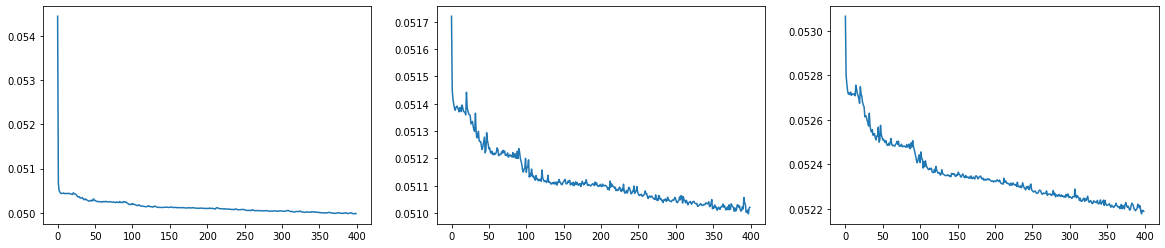

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 4))

ax1, ax2, ax3 = axes

ax1.plot(range(n_train_epochs), train_losses, label='Train loss')
ax2.plot(range(n_train_epochs), val_losses, label='Val loss')
ax3.plot(range(n_train_epochs), test_losses, label='Test loss')

In [10]:
# Load model with best per-validation loss (uncomment when ready)
best_epoch = load_state_dicts(out_file, model=model)
print('per-validation optimal epoch', best_epoch)

per-validation optimal epoch 398


1e0580f443a9e6d2593ebeeedbff73b 20


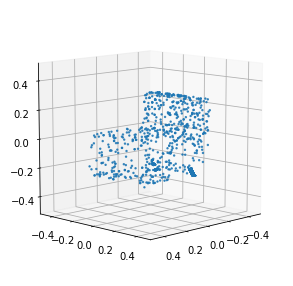

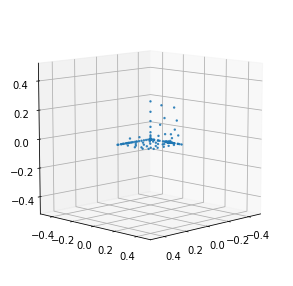

4e8d8792a3a6390b36b0f2a1430e993a 27


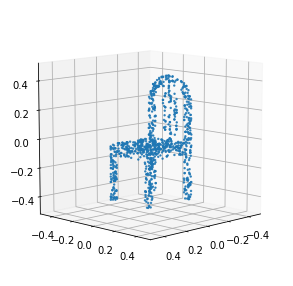

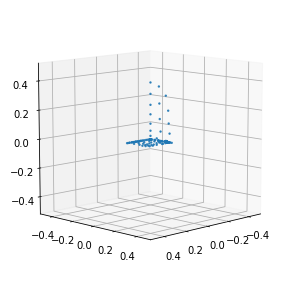

58479a7b7c157865e68f66efebc71317 44


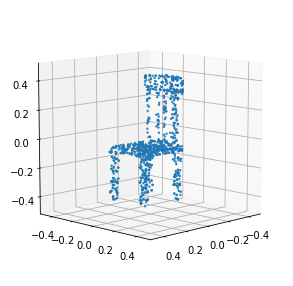

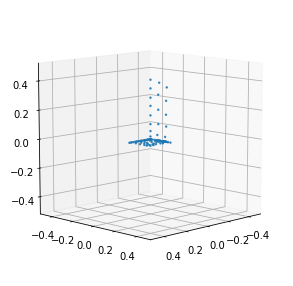

d3562f992aa405b214b1fd95dbca05 71


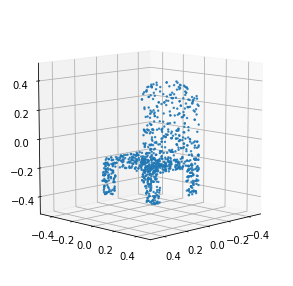

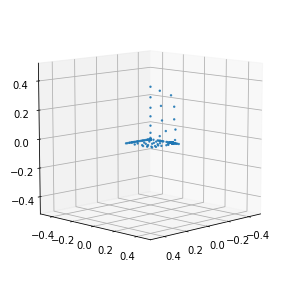

8a67fd47001e52414c350d7ea5fe2a3a 77


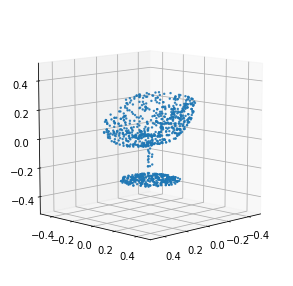

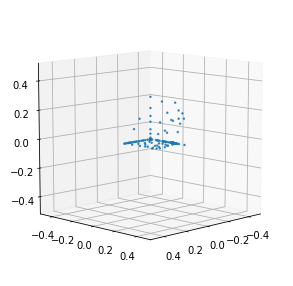

643cac07025f195750f9fc0e2c94dd76 69


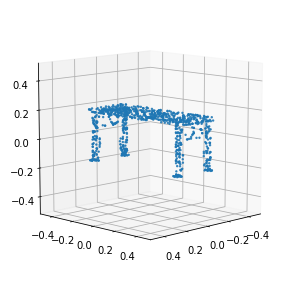

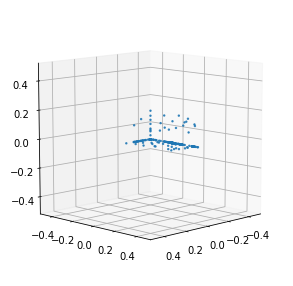

3e5a18ae1c8d5fe068d1b9a1d97e2846 37


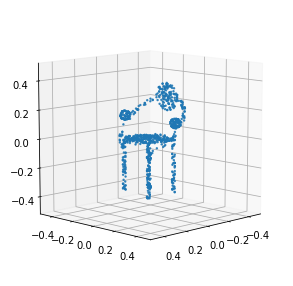

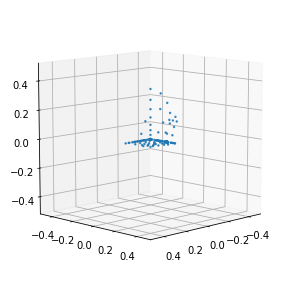

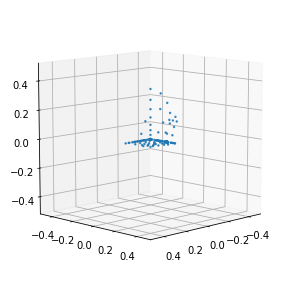

In [11]:
# MAKE your plots and analysis

# 5 examples to visualize per questions (e, f)
examples_to_visualize = ['8a67fd47001e52414c350d7ea5fe2a3a',
                         '1e0580f443a9e6d2593ebeeedbff73b',
                         'd3562f992aa405b214b1fd95dbca05',
                         '4e8d8792a3a6390b36b0f2a1430e993a',
                         '58479a7b7c157865e68f66efebc71317']

# You can (also) use the function for the reconstructions or the part-predictions 
# (for the latter check the kwargs parameter 'c' of matplotlib.
    # plot_3d_point_cloud, eg. try plot_3d_point_cloud(loaders['test'].dataset.pointclouds[0])
for i in range(len(loaders['test'].dataset.model_names)):
    if loaders['test'].dataset.model_names[i] in examples_to_visualize:
        print(loaders['test'].dataset.model_names[i], i)
        plot_3d_point_cloud(loaders['test'].dataset.pointclouds[i])
        plot_3d_point_cloud(recons[i].cpu())
amax = np.argmax(recon_losses)
amin = np.argmin(recon_losses)
print(loaders['test'].dataset.model_names[amax], amax)
plot_3d_point_cloud(loaders['test'].dataset.pointclouds[amax])
plot_3d_point_cloud(recons[amax].cpu())
print(loaders['test'].dataset.model_names[amin], amin)
plot_3d_point_cloud(loaders['test'].dataset.pointclouds[amin])
plot_3d_point_cloud(recons[amin].cpu())

In [12]:
# Last, save the latent codes of the test data and go to the 
# measuring_part_awareness and tsne_plot_with_latent_codes code.

model.eval()   # Do not forget this.! We are not training any more (OK, since we do not 
               # have batch-norm, drop-out etc. this is not so important, however it is good standard 
               # practice)
latent_codes = []
test_names = []

# Extract the latent codes and save them, so you can analyze them later.
for b in loaders['test']:
    pcloud = b['point_cloud'].to(device)
    
    test_name = b['model_name']
    test_names = test_names + test_name
    
    latent_code = model.embed(pcloud)
    latent_codes.append(latent_code)
    
latent_codes = torch.cat(latent_codes, dim=0)
latent_codes = latent_codes.cpu().numpy()

np.savez(osp.join(top_out_dir, model_tag +'_latent_codes'), 
         latent_codes=latent_codes, 
         test_names=test_names)